This notebook is designed to visualize the GaMMA result, like figures shown in https://github.com/AI4EPS/GaMMA/blob/master/docs/example_synthetic.ipynb

In [86]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyproj import Proj
import json
import pygmt

## Configs

In [60]:
center=(-178, -19)

In [89]:
with open("../data/stations.json") as json_file:
    stations_raw = json.load(json_file)
stations = pd.DataFrame(columns=["id", "x(km)", "y(km)", "z(km)","longitude","latitude"])
proj = Proj(
    f"+proj=sterea +lon_0={center[0]} +lat_0={center[1]} +units=km")
for key in stations_raw:
    row = stations_raw[key]
    x, y = proj(longitude=row["longitude"], latitude=row["latitude"]) # pylint: disable=unpacking-non-sequence
    z = -row["elevation_m"]/1000
    stations.loc[len(stations)] = [key, x, y, z,row["longitude"],row["latitude"]]
# calculate distance as sqrt(x^2+y^2)
stations["distance"] = (stations["x(km)"]**2+stations["y(km)"]**2)**0.5

In [90]:
stations.head()

,id,x(km),y(km),z(km),longitude,latitude,distance
0,YL.B01W..HH,312.034960,-118.762866,1.723,-175.018005,-20.048300,333.871883
1,YL.B03..BH,273.751404,-106.295665,2.015,-175.385498,-19.941401,293.664093
2,YL.B06..BH,226.215212,-89.088659,2.201,-175.841400,-19.792000,243.125711
3,YL.C02..BH,246.018470,-157.680054,2.062,-175.643494,-20.408899,292.212401
4,YL.C04..BH,217.472386,-132.352162,2.197,-175.919800,-20.183599,254.580701


## load data

In [99]:
df_global=pd.read_csv('../example_res/picks_global.csv',sep='\t',index_col=0)
df_catalog_global=pd.read_csv('../example_res/catalogs_global.csv',sep='\t',index_col=0)
# timestamp to datetime
df_global['timestamp']=pd.to_datetime(df_global['timestamp'])
df_catalog_global['time']=pd.to_datetime(df_catalog_global['time'])
# join df_global and df_catalog_global on event_index
df_global=df_global.join(df_catalog_global.set_index('event_index'),on='event_index',rsuffix='_catalog')
# join df_global and distance in station on id
df_global=df_global.join(stations.set_index('id'),on='id',rsuffix='_station')

In [100]:
# split df_global with event_index into a list of dataframes
df_global_list = [df_global[df_global['event_index'] == i].copy() for i in df_global['event_index'].unique()]

# for each dataframe in df_global_list, calculate tshift=t_pick-t_catalog
# using .loc[row_indexer,col_indexer] = value syntax
for df in df_global_list:
    df.loc[:, 'tshift'] = df['timestamp'] - df['time']
    # convert tshift to seconds
    df.loc[:, 'tshift'] = df['tshift'].apply(lambda x: x.total_seconds())


In [101]:
df_global_list[0].iloc[0]

event_id                                  3_52566
id                                    Z1.EUAP..BH
timestamp              2010-06-29 08:17:38.999997
amp                                      0.000001
type                                            p
prob                                          1.0
event_index                                     0
gamma_score                              0.093485
time                   2010-06-29 08:16:17.366000
x(km)                                   96.812066
y(km)                                   78.596179
z(km)                                  553.389933
magnitude                                     999
sigma_time                               0.416808
sigma_amp                                       0
cov_time_amp                                    0
gamma_score_catalog                           8.0
longitude                             -177.084412
latitude                               -18.287704
depth(m)                            553389.933313


In [149]:
ground_truth_mapper={
    2:(pd.to_datetime("2009-12-26T05:15:54.969999"),proj(latitude=-20.4003,longitude=-175.5445),168.4243),
    0:(pd.to_datetime("2010-06-29T08:16:13.949997"),-17.6654,-177.7512,523.6898),
    1:(pd.to_datetime("2010-05-14T10:33:23.950001"),-20.1968,-177.1223)
}
ground_truth_mapper

{2: (Timestamp('2009-12-26 05:15:54.969999'),
  (256.3692360444372, -156.87402972360098),
  168.4243),
 0: (Timestamp('2010-06-29 08:16:13.949997'), -17.6654, -177.7512, 523.6898),
 1: (Timestamp('2010-05-14 10:33:23.950001'), -20.1968, -177.1223)}

16.583997


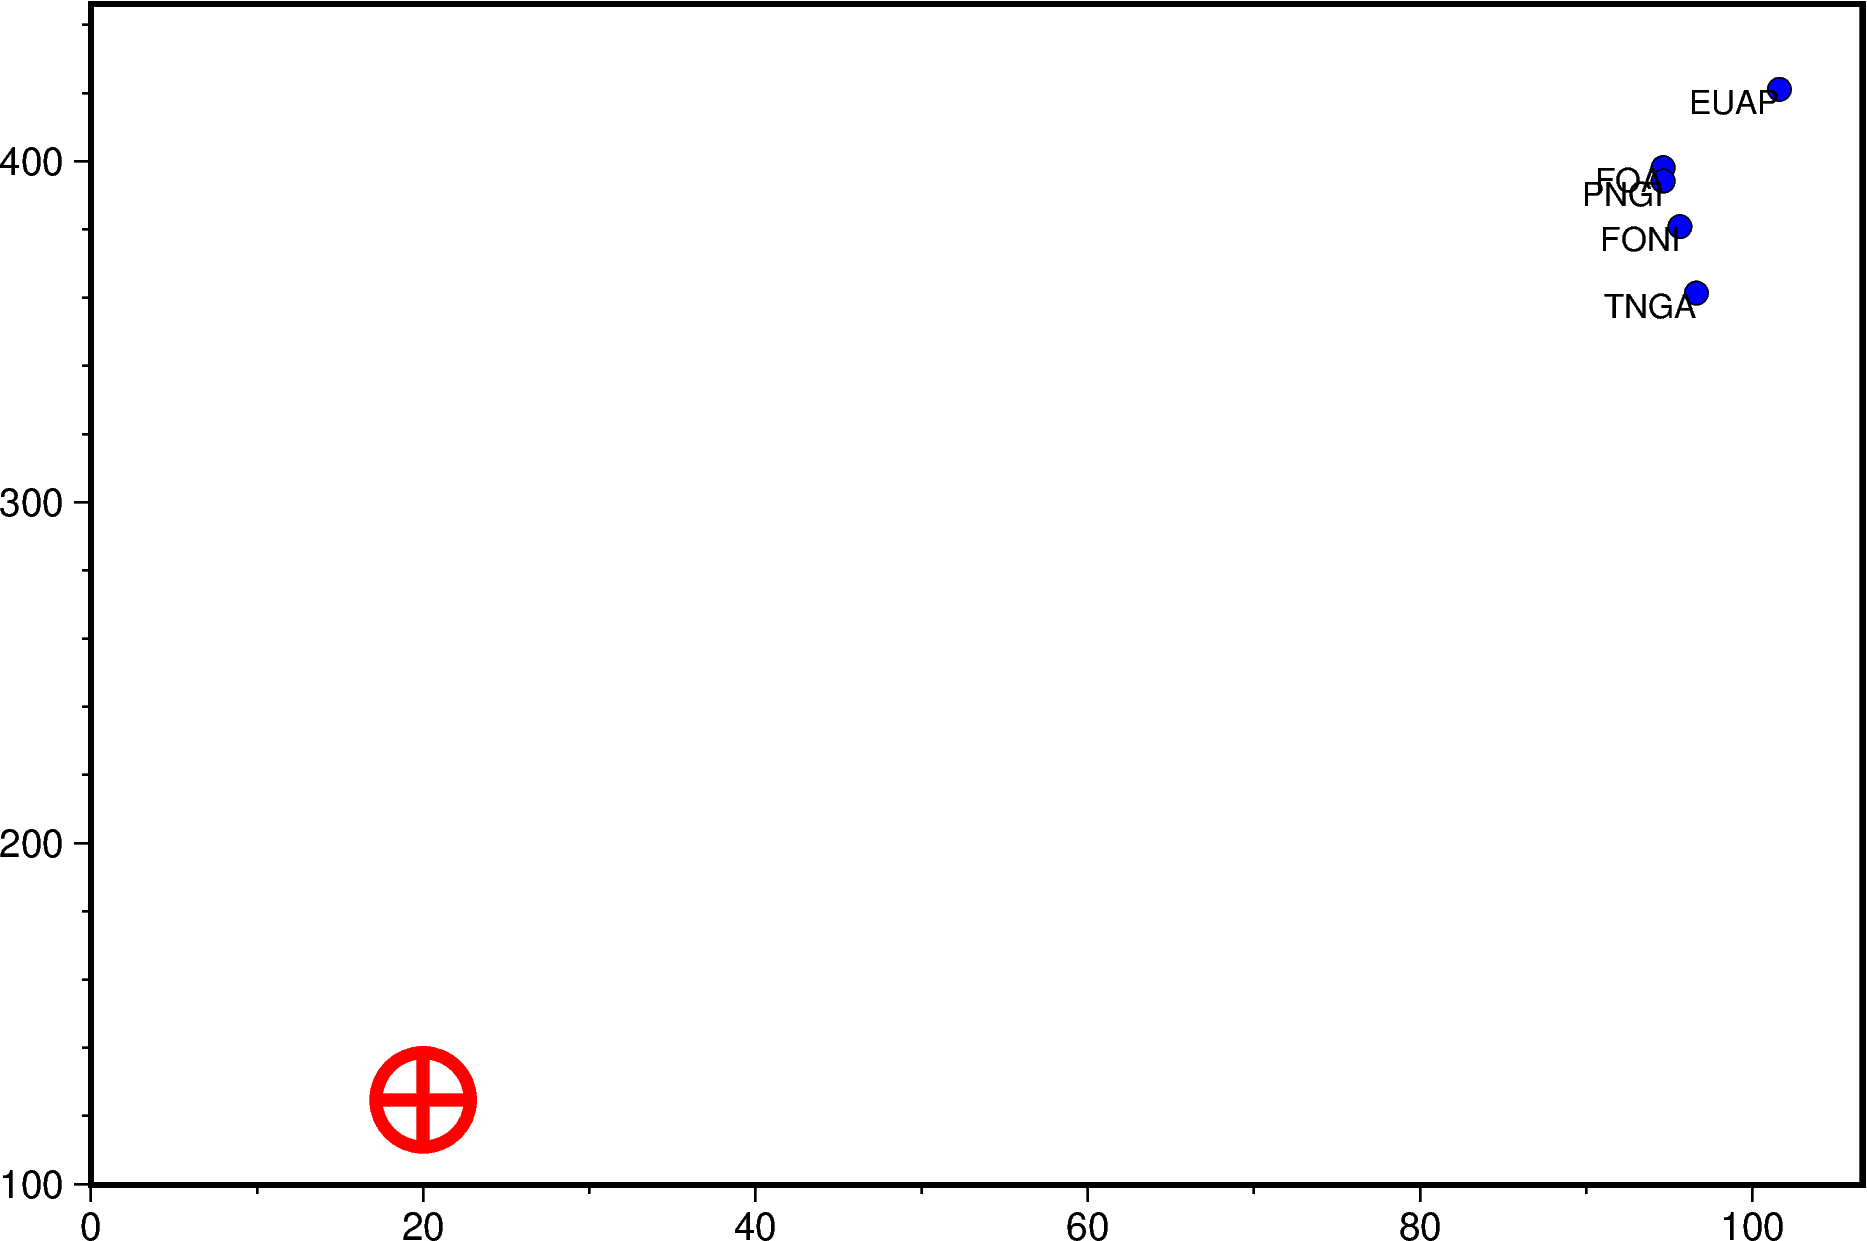

In [146]:
def plot(df,index):
    df = df[df['type'] == 'p']
    df.loc[:, 'tshift'] = df['tshift'] + 20
    
    fig = pygmt.Figure()

    x = 20
    y = (df.iloc[0]['x(km)']**2 + df.iloc[0]['y(km)']**2)**0.5
    
    # Create a scatter plot using PyGMT
    fig.plot(
        x=df['tshift'],
        y=df['distance'],
        style='c0.2c',
        fill='blue',
        pen='black',
        projection='X15c/10c',
        region=[0, df['tshift'].max()+5, min(df['distance'].min(),y)-25, max(df['distance'].max(),y)+25],
        frame=True
    )
    
    # Plot the event origin location
    fig.plot(x=x, y=y, style="c0.8c", fill=None, pen="3p,red")
    fig.plot(x=x, y=y, style="+0.8c", pen="3p,red")
    
    # Label the station id with non-overlapping
    for i in range(len(df)):
        fig.text(x=df.iloc[i]['tshift'], y=df.iloc[i]['distance'], text=df.iloc[i]['id'].split(".")[1], font='8p', justify='TR')

    print((ground_truth_mapper[index][0]-df.iloc[0]['time']).total_seconds()+20)
    
    fig.show()

plot(df_global_list[0],0)


-177.08441163009132 -18.287704489507743
-17.6654 -177.7512


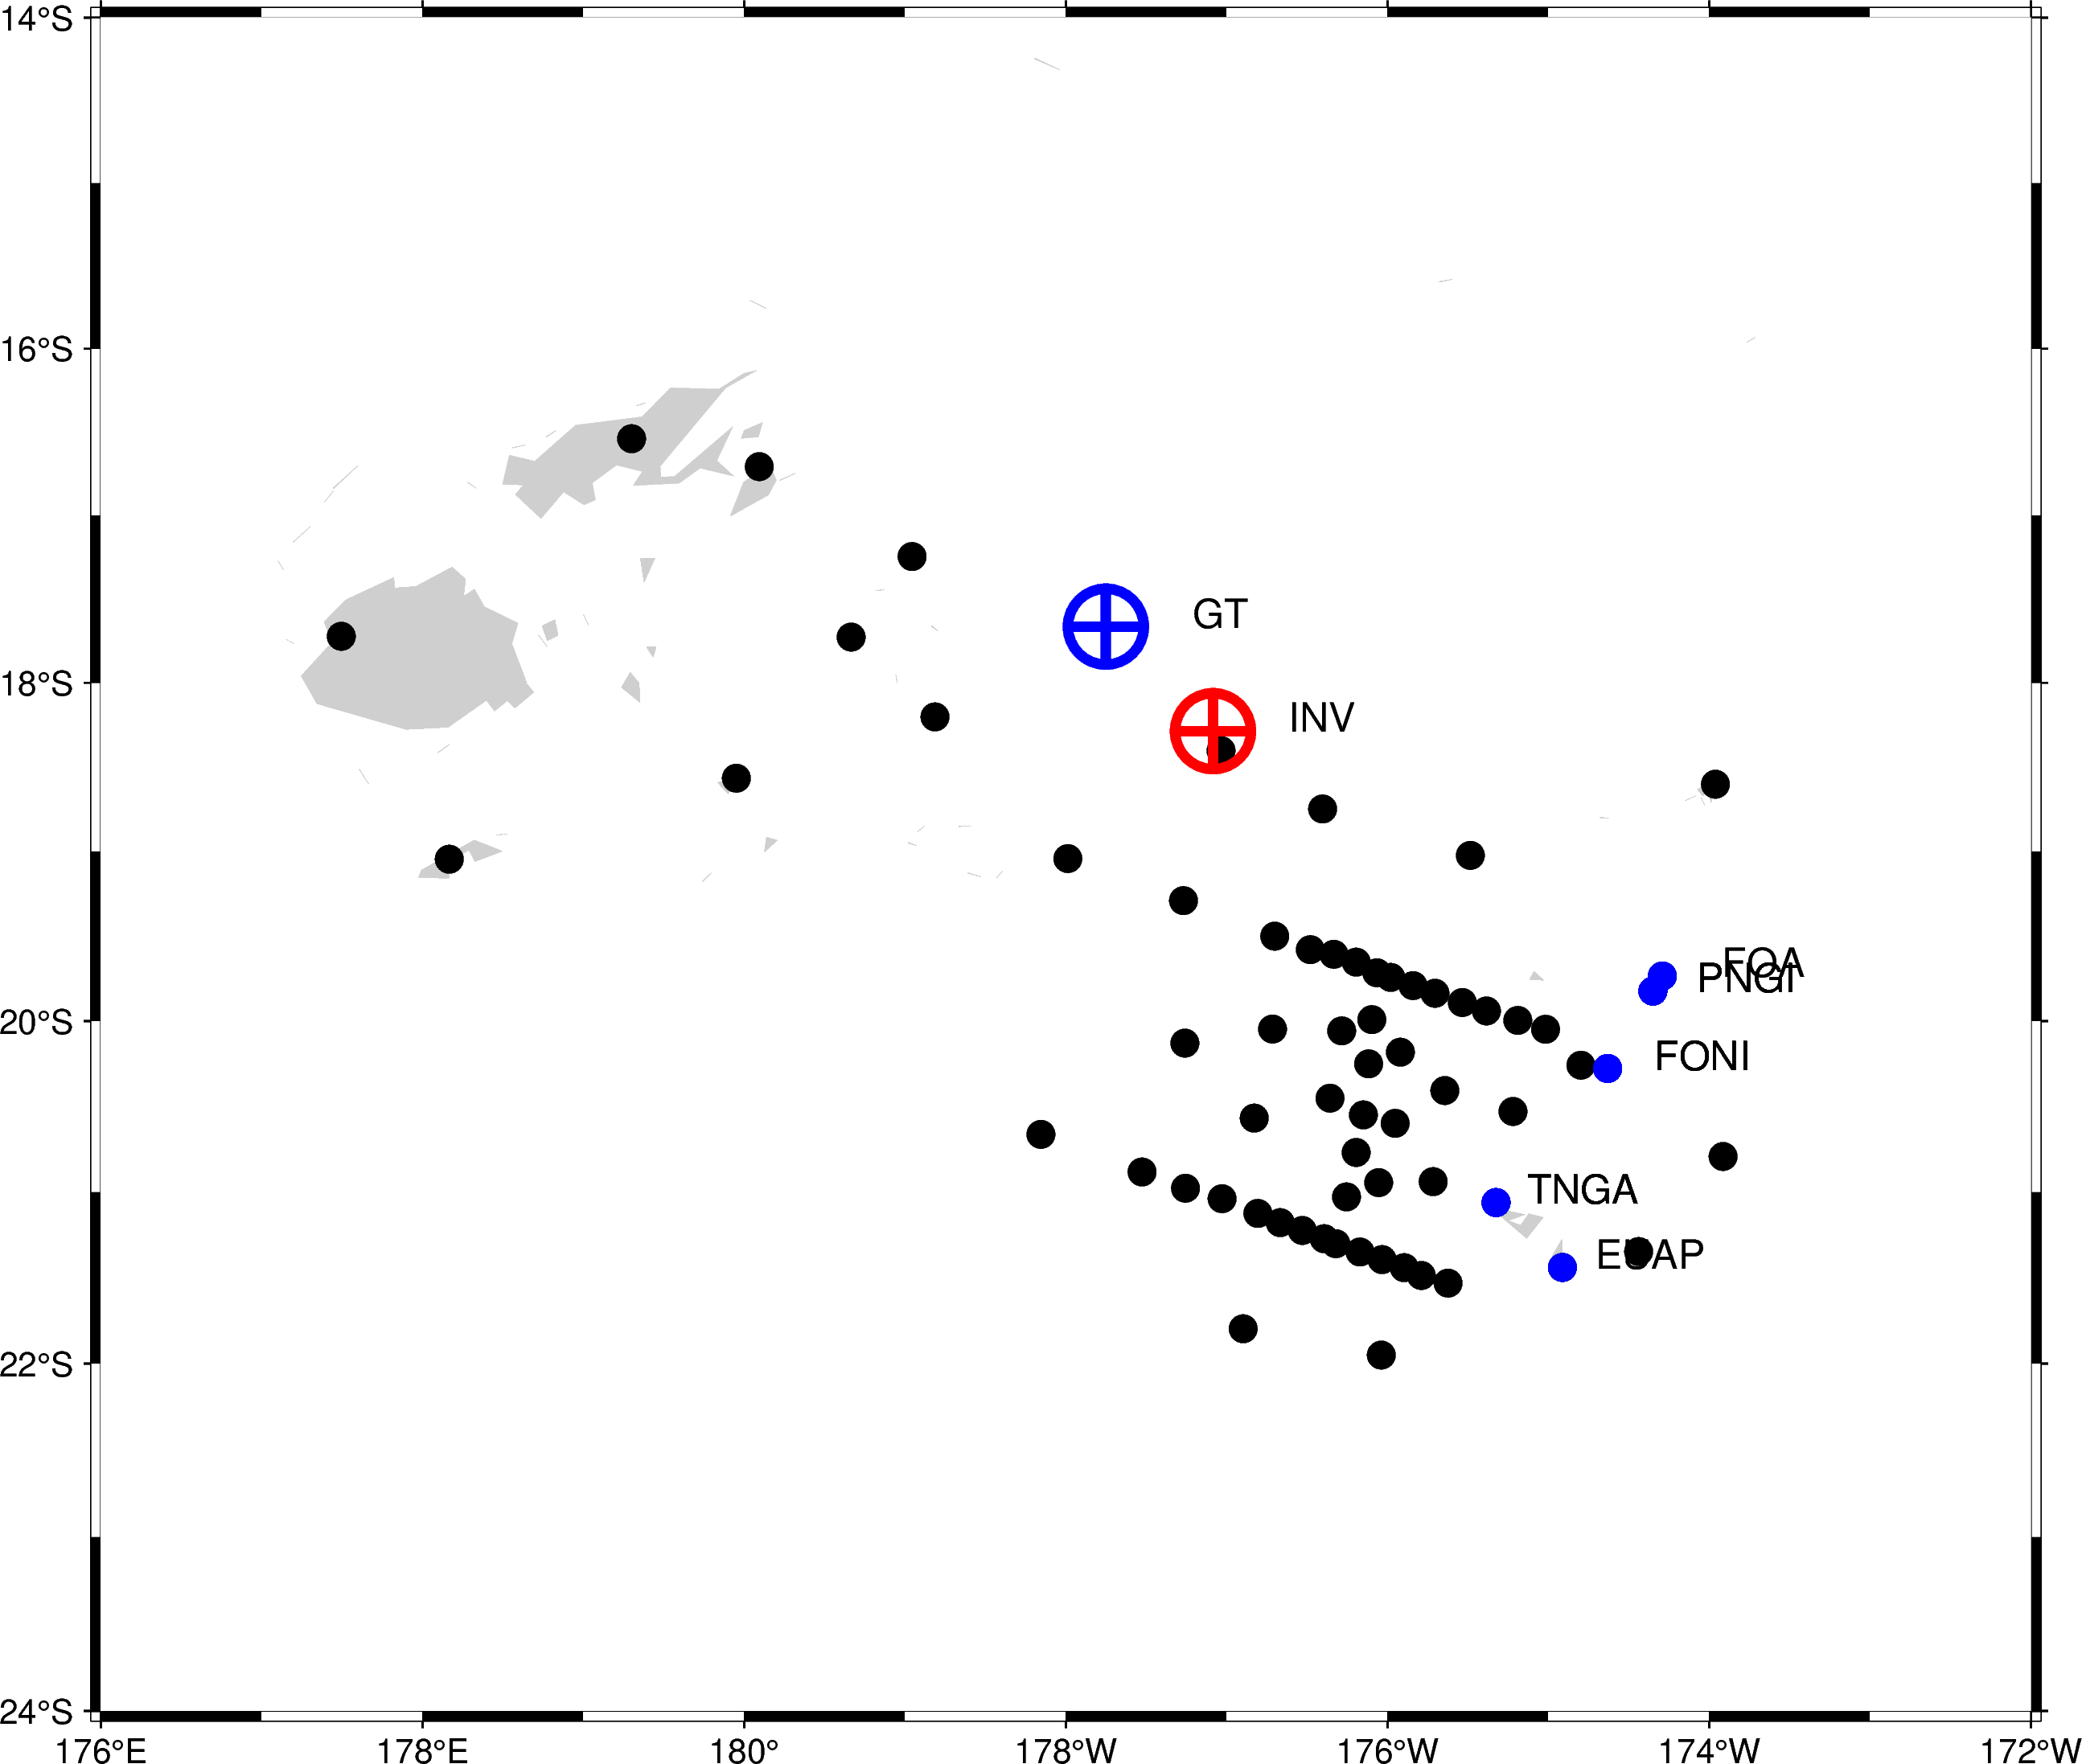

In [156]:
# show the stations' locations on the map using pygmt
def show_map(df,index):
    REGION=[-184, -172, -24, -14]

    fig = pygmt.Figure()
    fig.basemap(region=REGION, projection="M8i",
                        frame=["WSen", "xafg", "yafg"])
    fig.coast(water="white", resolution="l", land="GRAY81",
                borders=["1/0.1p,black"], lakes=["GRAY81"])
    fig.plot(x=stations['longitude'], y=stations['latitude'], style="c0.3c", fill="black")
    # plot longitude and latitude of stations in df in red color
    fig.plot(x=df['longitude_station'], y=df['latitude_station'], style="c0.3c", fill="blue")
    # also text the station id
    for i in range(len(df)):
        fig.text(x=df.iloc[i]['longitude_station'], y=df.iloc[i]['latitude_station'], text=df.iloc[i]['id'].split(".")[1], font='12p', justify='TR',offset="1.5c/0.3c")
    # plot event origin (longitude, latitude) in big circle with no fill
    print(df.iloc[0]['longitude'], df.iloc[0]['latitude'])
    fig.plot(x=df.iloc[0]['longitude'], y=df.iloc[0]['latitude'], style="c0.8c", fill=None, pen="3p,red")
    fig.plot(x=df.iloc[0]['longitude'], y=df.iloc[0]['latitude'], style="+0.8c", pen="3p,red")
    fig.text(x=df.iloc[0]['longitude'], y=df.iloc[0]['latitude'], text="INV", font='12p', justify='TR',offset="1.5c/0.3c")
    print(ground_truth_mapper[index][1],ground_truth_mapper[index][2])
    fig.plot(x=ground_truth_mapper[index][2], y=ground_truth_mapper[index][1], style="c0.8c", fill=None, pen="3p,blue")
    fig.plot(x=ground_truth_mapper[index][2], y=ground_truth_mapper[index][1], style="+0.8c", pen="3p,blue")
    fig.text(x=ground_truth_mapper[index][2], y=ground_truth_mapper[index][1], text="GT", font='12p', justify='TR',offset="1.5c/0.3c")

    fig.show()

show_map(df_global_list[0],0)